# Homework

## Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

## Answer to Q1

The starter distributions from the previous homework are the following: <br>

1. $p(\theta) = N(\theta_0, \tau_0) = \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}(\theta-\theta_0)^2}$ 

2. $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$

3. $f(\mathbf{x}|\theta, \tau) = \prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2}(x_i-\theta)^2}$

### Import Libraries

In [7]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

### Metropolis within Gibbs Sampler

In [20]:
# loc is mean and scale is standard deviation
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

# Hyperparameters for theta prior
theta_0 = 0  
tau_0 = 5  

# Hyperparameters for tau prior
alpha_prior = 2 
lambda_prior = 1  

C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
tau[:, 0] = 1
theta[:,0] = 0  # initialization

for c in range(C):
    for g in range(1,G):

        # the likelihood*prior as a function of tau
        # is proportional to the full conditional of tau
        # all of which are proportion to the joint as a function of tau
        
        # Tau
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1],
                                                     scale=1/(tau_)**0.5).pdf(x))*\
                                  stats.gamma(a=alpha_prior/2, scale=2/lambda_prior).pdf(tau_) 
        
        tau_propsal = stats.gamma(a=alpha_prior/2, scale=2/lambda_prior)

        tau_tilde = tau_propsal.rvs()
        
        mh_calc_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * \
                  (tau_propsal.pdf(tau[c, g-1]) / tau_propsal.pdf(tau_tilde))
        
        acceptance_probability_tau = min(1, mh_calc_tau)
        
        if stats.uniform().rvs() < acceptance_probability_tau:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]
        
        # Theta
        theta_target = lambda theta_ : np.prod(stats.norm(loc=theta[c,g-1],
                                                          scale=1/(tau[c,g])**0.5).pdf(x))*\
                                        stats.norm(loc=theta_0, scale = 1/(tau_0)**0.5).pdf(theta_)
        
        theta_propsal = stats.norm(loc=theta[c,g-1],scale=1/(tau_0)**0.5)
        
        theta_tilde = theta_propsal.rvs()
        
        mh_calc_theta = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * \
                  (theta_propsal.pdf(theta[c, g-1]) / theta_propsal.pdf(theta_tilde))
        
        acceptance_probability_theta = min(1, mh_calc_theta)
        
        if stats.uniform().rvs() < acceptance_probability_theta:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]

#### Visualization

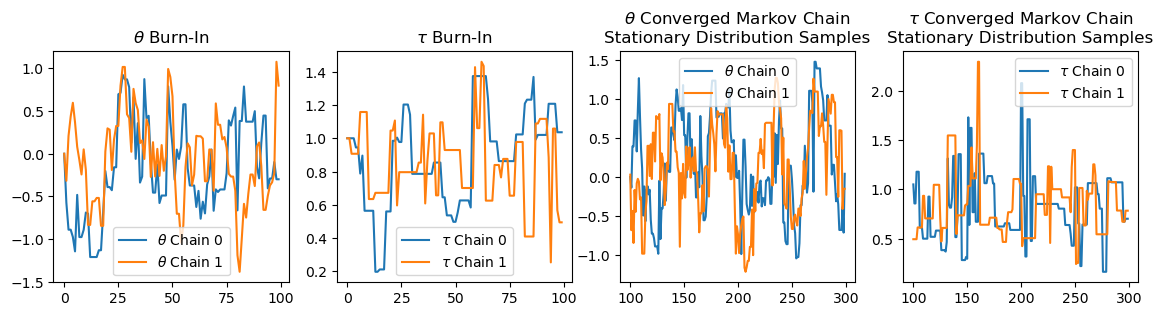

In [25]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 100
demo = 300
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

### Bayesian Inferences from  Metropolis within Gibbs Sampler

The 95% credible intervals for $\theta$ and $\tau$, respectively, are the following:

In [26]:
# 95% credible interval for theta
print(np.quantile(theta[0,burn:], [0.025, 0.975]))

[-1.08633043  1.12333659]


The 95% credible interval for $\tau$ is the following:

In [27]:
# 95% credible interval for tau
print(np.quantile(tau[0,burn:], [0.025,0.975]))

[0.34157411 1.43343215]


#### Running Gibbs Sampler from Homework 3 to Generate Credible Intervals to Compare

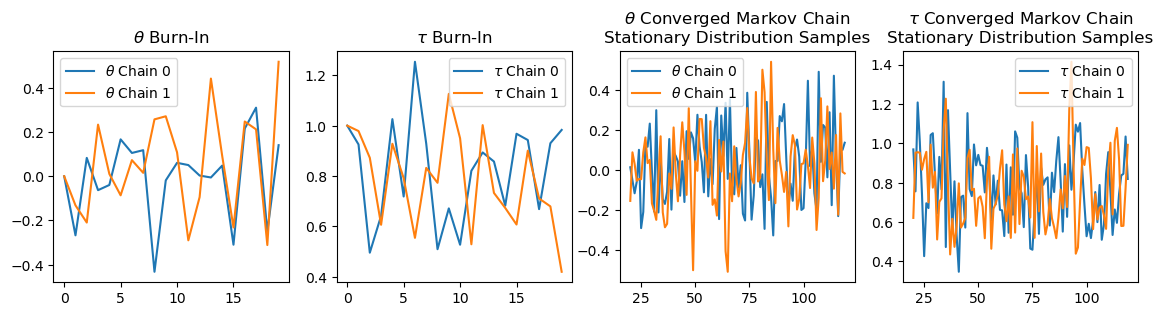

In [30]:
# loc is mean and scale is standard deviation
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

# Hyperparameters for theta prior
theta_0 = 0  
tau_0 = 5  

# Hyperparameters for tau prior
alpha_prior = 2 
lambda_prior = 1  

C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
tau[:, 0] = 1
theta[:,0] = 0  # initialization

for c in range(C):
    for g in range(1,G):\
        # Tau
        alpha_post = (alpha_prior + n) / 2
        beta_post = (lambda_prior + np.sum((x - theta[c, g - 1])**2)) / 2
        tau[c, g] = stats.gamma(a=alpha_post, scale=1 / beta_post).rvs()

        # Theta
        tau_ratio = tau_0 / tau[c, g] 
        numerator = (n * x.mean()) + (tau_ratio * theta_0)
        denominator = n + tau_ratio

        mu_post = numerator / denominator  
        sigma_post = (1 / (n * tau[c, g] + tau_0))**0.5 

        theta[c, g] = stats.norm(loc=mu_post, scale=sigma_post).rvs()

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

### Bayesian Inferences from Gibbs Sampler

The 95% credible intervals for $\theta$ and $\tau$, respectively, are the following:

In [31]:
# 95% credible interval for theta using Gibbs Sampling
print(np.quantile(theta[0,burn:], [0.025, 0.975]))

# 95% credible interval for tau using Gibbs Sampling
print(np.quantile(tau[0,burn:], [0.025,0.975]))

[-0.3802548   0.37913325]
[0.43332519 1.17725173]


### Discussion

The specifications for this model include the normal prior for $\theta$ and gamma prior for $\tau$ used in Homework 3. The target distribution was proportional to the likelihood multiplied by the priors since any irrelevant priors would cancel in the ratio, as stated in the question. The prior was used as the proposal ditribution for $\tau$ as suggested in the question as independent samples can be generated, while a normal distribution centred at the previous $\theta$ and a fixed variance was used as $\theta$'s proposal distribution. Overall, the 95% credible intervals in the Metropolis Hastings within Gibbs sampler were wider. The larger credible intervals may be due to a variety of reasons. Convergence may happen more slowly due to rejected proposals and autocorrelation. Low acceptance rates may lead to wider intervals and inefficiencies in exploring the posterior. In general, if any proposal distributions or tuning parameters are poorly chosen, this can also make the credible interval less effective, introducing more variability or bias.

## Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

## Answer to Q2

In [36]:
# loc is mean and scale is standard deviation
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

s = 5

alpha_prior = 10 
lambda_prior = 5  

C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
tau[:, 0] = 1
theta[:,0] = 0  # initialization

for c in range(C):
    for g in range(1,G):

        # the likelihood*prior as a function of tau
        # is proportional to the full conditional of tau
        # all of which are proportion to the joint as a function of tau
        
        # Tau
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1],
                                                     scale=1/(tau_)**0.5).pdf(x))*\
                                  stats.gamma(a=alpha_prior/2, scale=2/lambda_prior).pdf(tau_) 
        
        a = -tau[c, g-1] / s  
        b = np.inf  
        tau_propsal = stats.truncnorm(a=a, b=b, loc=tau[c,g-1], scale=s)
        
        tau_tilde = tau_propsal.rvs()
        
        mh_calc_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * \
                  (tau_propsal.pdf(tau[c, g-1]) / tau_propsal.pdf(tau_tilde))
        
        acceptance_probability_tau = min(1, mh_calc_tau)
        
        if stats.uniform().rvs() < acceptance_probability_tau:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]
        
        
        # Theta (Uniform prior)
        theta_target = lambda theta_ : np.prod(stats.norm(loc=theta[c,g-1],
                                                          scale=1/(tau[c,g])**0.5).pdf(x))*\
                                        stats.uniform(loc=0, scale=1).pdf(theta_) 
        
        theta_propsal = stats.norm(loc=theta[c,g-1],scale=1/(tau_0)**0.5)
        
        theta_tilde = theta_propsal.rvs()
        
        mh_calc_theta = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * \
                  (theta_propsal.pdf(theta[c, g-1]) / theta_propsal.pdf(theta_tilde))
        
        acceptance_probability_theta = min(1, mh_calc_theta)
        
        if stats.uniform().rvs() < acceptance_probability_theta:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]
        

#### Visualization

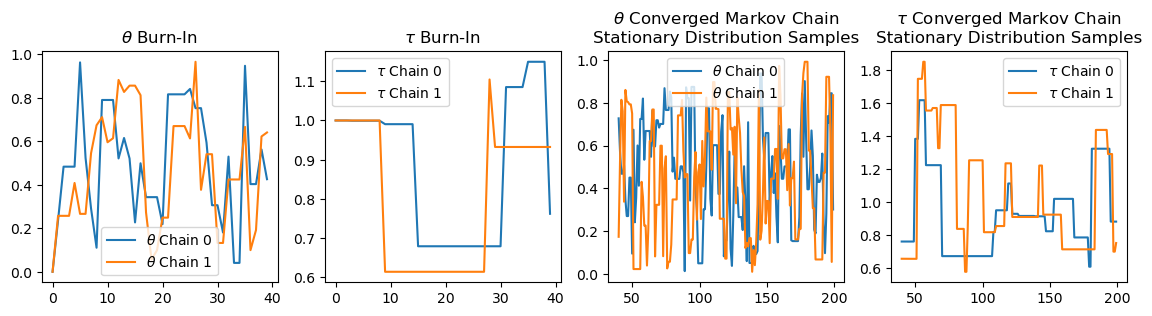

In [37]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 40
demo = 200
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

### Bayesian Inference

The 95% credible interval for $\theta$ is the following:

In [38]:
# 95% credible interval for tau
print(np.quantile(theta[0,burn:], [0.025,0.975]))

[0.02635654 0.97774147]


The 95% credible interval for $\tau$ is the following:

In [39]:
# 95% credible interval for tau
print(np.quantile(tau[0,burn:], [0.025,0.975]))

[0.48024438 1.6847701 ]


### Discussion

The Gibbs sampling used here does not require one to analytically determine the full conditional distribution of a parameter. Instead, this method only relies on the ratios of the target and proposal distributions. We therefore only need the posterior distribution up to a constant. Moreover, it is ideal to use this when directly sampling from the posterior distribution is not possible or extremely difficult.

## Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


This means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


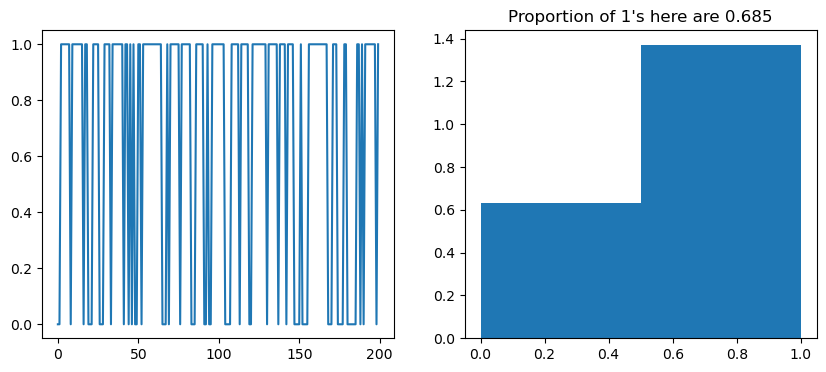

In [3]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

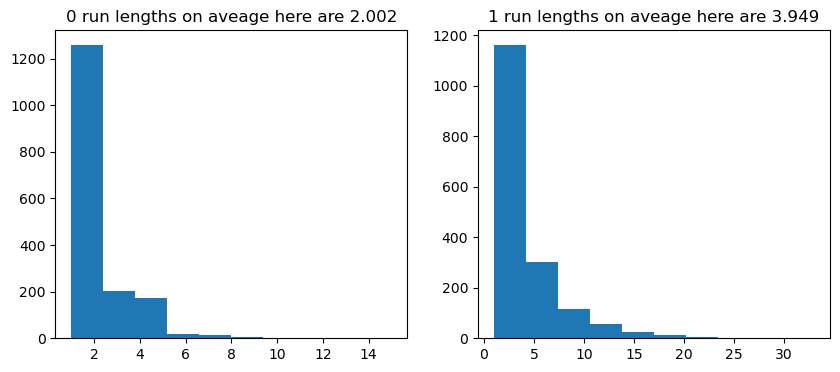

In [4]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


## Answer to Q3

The transition kernel was given in class:
$p(x^{(t)}|x^{(t-1)}) = q(\tilde x^{(t)} | x^{(t-1)}) P_{a} (x^{(t)} = \tilde x^{(t)})$, where $P_{a} = \min\left(1,\frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})}\right)$

We are also given this information: <br>
$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

Our proposal distribution tells us that if the previous state is 0, the new state is equally likely to be 0 or 1: $q(0|0) = q(1|0) = 0.5$. It also tells us that if the previous state is 1, then the new state is equally likely to be 0 or 1: $q(0|1) = q(1|1) = 0.5$. Our target distribution tells us that $p(0) = 1/3$ and $p(1) = 2/3$. Since $q$ is symmetric in this case, the acceptance probability becomes the following: $P_{a} = \min\left(1,\frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\right)$

$P_{a}(1|1)=\min\left(1,\frac{p(1)}{p(1)}\right)$ and $P_{a} (0|0)=\min\left(1,\frac{p(0)}{p(0)}\right)$ both equal to 1.
Calculating $P_{a}=\min\left(1,\frac{p(1)}{p(0)}\right)$ and $P_{a}=\min\left(1,\frac{p(0)}{p(1)}\right)$, we get the following results: <br>
$P_{a}(1|0)=\min\left(1,\frac{p(1)}{p(0)}\right) = \min\left(1,\frac{2/3}{1/3}\right) = 1$ <br>
$P_{a}(0|1)=\min\left(1,\frac{p(0)}{p(1)}\right) = \min\left(1,\frac{1/3}{2/3}\right) = 0.5$

Calculate the values in the transition kernel: <br>
$p(0|0) = q(0|0)P_{a}(0|0) + q(1|0)(1 - P_{a}(1|0)) = (0.5*1) + 0 = 0.5$ <br>
$p(0|1) = q(0|1) P_{a}(0|1) = 0.5*0.5 = 0.25$ <br>
$p(1|0) = q(1|0) P_{a}(1|0) = 0.5*1 = 0.5$ <br>
$p(1|1) = q(1|1) P_{a}(1|1) + q(0|1)(1-P_{a}(0|1)) = (0.5*1) + (0.5*0.5) = 0.75$ <br>

$K = \left[\begin{array}{cc}p(0|0) & p(0|1)\\ p(1|0)& p(1|1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

Therefore, we get the final result:

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$
